In [6]:
import torch
import torch.nn as nn
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import math


The paper "Improved Denoising Diffusion Probabilistic Models" 2020 by OpenAI proposed to use a different noise scheduler in terms of $\bar{\alpha_t}$:

$$
\bar{\alpha_t} = \frac{f(t)}{f(0)}
$$

where

$$
f(t) = cos (\frac{t/T + s}{1 + s} \cdot \frac{\pi}{2})^2
$$

where $s$ is a hyperparameter that controls the amount of noise added to the image.

In [ ]:
# Cosine noise scheduler class
class CosineNoiseScheduler:
    """
    s = 0.008 is set by the authors of the paper (section 3.2)
    """
    def __init__(self, timesteps, s=0.008):
        self.timesteps = timesteps
        self.s = s
        self.betas = self._cosine_beta_schedule()
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def _cosine_beta_schedule(self):
        steps = self.timesteps + 1
        t = torch.linspace(0, self.timesteps, steps) / self.timesteps
        alphas_bar = torch.cos(((t + self.s) / (1 + self.s)) * math.pi * 0.5) ** 2
        alphas_bar = alphas_bar / alphas_bar[0]
        betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
        return torch.clamp(betas, max=0.999)

    def add_noise(self, x0, t):
        alpha_bar = self.alpha_cumprod[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x0)
        return torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise

Load CIFAR-10 dataset

In [8]:
transform = T.Compose([
    T.ToTensor(),  # converts to [0, 1]
    T.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
])
dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
img, label = dataset[0]  # get a single image
x0 = img.unsqueeze(0)  # add batch dimension

Apply noise scheduler

In [9]:
def plot(timesteps, beta_start, beta_end, plotted_timesteps):
    scheduler = CosineNoiseScheduler(timesteps=timesteps, beta_start=beta_start, beta_end=beta_end)
    noisy_images = []

    for t in plotted_timesteps:
        timestep = torch.tensor([t])
        noisy_img = scheduler.add_noise(x0, timestep)
        noisy_images.append(noisy_img)

    num_images = len(plotted_timesteps)
    cols = num_images  # All in one row
    rows = 1

    def show_image(tensor, title=""):
        img = tensor.clone().detach().cpu()
        img = img * 0.5 + 0.5  # unnormalize
        img = img.clamp(0, 1)  # clip to [0, 1]
        img = img.squeeze().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.figure(figsize=(3 * cols, 3))  # Wider figure for single row
    for i, (t, img) in enumerate(zip(plotted_timesteps, noisy_images)):
        plt.subplot(rows, cols, i + 1)
        show_image(img, f"t={t}")

    plt.suptitle(f"Diffusion Noise Over Time (beta_start = {beta_start}, beta_end = {beta_end})", fontsize=14)
    plt.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.3, hspace=0.01)
    plt.show()

In [10]:
plotted_timesteps = list(range(0, 501, 50))  # [0, 50, 100, ..., 500]
plot(timesteps=1000, beta_start=1e-4, beta_end=0.02, plotted_timesteps=plotted_timesteps)

TypeError: CosineNoiseScheduler.__init__() got an unexpected keyword argument 'beta_start'

Less destruction when $\beta_{\text{end}}$ is smaller

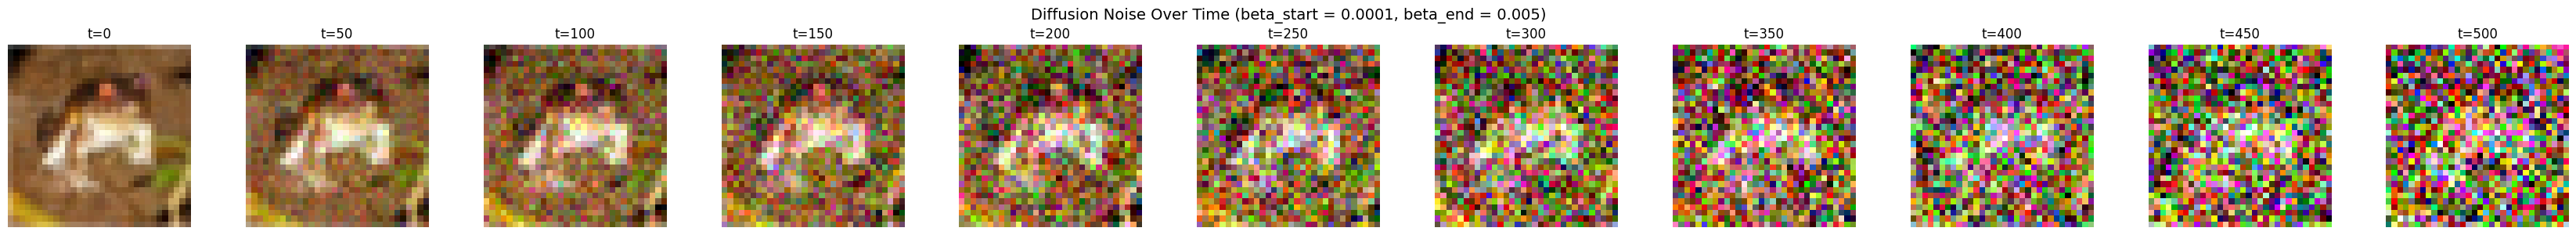

In [ ]:
plotted_timesteps = list(range(0, 501, 50))  # [0, 50, 100, ..., 500]
plot(timesteps=1000, beta_start=1e-4, beta_end=0.005, plotted_timesteps=plotted_timesteps)